#  STEP 7: Making predictions for tommorow 

## Preparing Data

In [ ]:
data_t = preprocessor.fit_transform(data)

data_transformed_days = pd.DataFrame(data_t)
data_transformed_days
data_transformed_days.columns = ['Wind_direction', 'Pollution', 'Dew_point', 'Temprerature', 'Pressure', 'Wind_speed', 'Snow', 'Rain']
data_transformed_days.index = data.index
data_transformed_days

## Creating new features

In [ ]:
mean_pollution = []
mean_dew_point = []
mean_temperature = []
mean_pressure = []
mean_wind_speed = []
amount_of_snow = []
amount_of_rain = []


for i in range(int(data_transformed_days.shape[0] / 24)):
    pollution = []
    dew_point = []
    temperature = []
    pressure = []
    wind_speed = []
    snow = []
    rain = []
    
    for raw in data_transformed_days.iloc[(i*24):((i+1)*24), :].itertuples():
        pollution.append(raw.Pollution)
        dew_point.append(raw.Dew_point)
        temperature.append(raw.Temprerature)
        pressure.append(raw.Pressure)
        wind_speed.append(raw.Wind_speed)
        snow.append(raw.Snow)
        rain.append(raw.Rain)
        
    mean_pollution.append(np.mean(pollution))
    mean_dew_point.append(np.mean(dew_point))
    mean_temperature.append(np.mean(temperature))
    mean_pressure.append(np.mean(pressure))
    mean_wind_speed.append(np.mean(wind_speed))
    amount_of_snow.append(np.sum(snow))
    amount_of_rain.append(np.sum(rain))

## Slicing dataset to days

In [ ]:
data_transformed_days = data_transformed_days.iloc[::24, :]
data_transformed_days

In [ ]:
# adding new features
data_transformed_days['Mean_pollution'] = mean_pollution
data_transformed_days['Mean_dew_point'] = mean_dew_point
data_transformed_days['Mean_temperature'] = mean_temperature
data_transformed_days['Mean_pressure'] = mean_pressure
data_transformed_days['Mean_wind_speed'] = mean_wind_speed
data_transformed_days['Amount_of_snow'] = amount_of_snow
data_transformed_days['Amount_of_rain'] = amount_of_rain

# dropping old features
data_transformed_days.drop(labels = ['Pollution', 'Dew_point', 'Temprerature', 'Pressure', 'Wind_speed', 'Snow', 'Rain'], axis = 1, inplace = True)

In [ ]:
#Scaling
scaler = MinMaxScaler()
data_transformed_days_t = scaler.fit_transform(data_transformed_days)
data_transformed_days_t = pd.DataFrame(data_transformed_days_t)
data_transformed_days_t.columns = data_transformed_days.columns
data_transformed_days_t.index = data_transformed_days.index
data_transformed_days_t

In [ ]:
# creating the predicted pollution for next day
data_transformed_days_t['Predicted_pollution'] = data_transformed_days_t['Mean_pollution'].shift(-1)
data_transformed_days_t

In [ ]:
data_transformed_days_t.drop(data_transformed_days_t.tail(1).index, inplace = True)
data_transformed_days_t.tail()

## Spliting to train / test sets

In [63]:
train_days = data_transformed_days_t.values[:(365 * 4)]
test_days = data_transformed_days_t.values[(365 * 4):]

train_X_days, train_y_days = train_days[:, :-1], train_days[:, -1]
test_X_days, test_y_days = test_days[:, :-1], test_days[:, -1]

train_X_days = train_X_days.reshape((train_X_days.shape[0], 1, train_X_days.shape[1]))
test_X_days = test_X_days.reshape((test_X_days.shape[0], 1, test_X_days.shape[1]))

train_X_days.shape, train_y_days.shape, test_X_days.shape, test_y_days.shape

((1460, 1, 8), (1460,), (364, 1, 8), (364,))

## Callbacks

In [64]:
checkpoint = ModelCheckpoint(
    filepath = './base/model_RNN_days_weights.h5py',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    mode = 'min',
    save_weights_only = True,
    save_freq = 'epoch'
)

earlyStop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 50,
    verbose = 1,
    mode = 'min'
)

callbacks = [checkpoint, earlyStop]

#  Train RNN Model with 2 hidden layers 

In [65]:
model_days = Sequential([
    LSTM(100, return_sequences = True, input_shape = (train_X_days.shape[1], train_X_days.shape[2])),
    LSTM(100),
    Dense(1)
])

model_days.compile(loss = 'mean_squared_error', optimizer = 'adam')
history_days = model_days.fit(
    train_X_days,
    train_y_days,
    epochs = 100,
    batch_size = 50,
    validation_data = (test_X_days, test_y_days),
    verbose = 1,
    callbacks = callbacks,
    shuffle = False
)


Epoch 1/100
27/30 [==========================>...] - ETA: 0s - loss: 0.0270
Epoch 1: val_loss improved from inf to 0.02290, saving model to ./base\model_RNN_days_weights.h5py
30/30 [==============================] - 3s 30ms/step - loss: 0.0266 - val_loss: 0.0229
Epoch 2/100
29/30 [============================>.] - ETA: 0s - loss: 0.0182
Epoch 2: val_loss improved from 0.02290 to 0.02039, saving model to ./base\model_RNN_days_weights.h5py
30/30 [==============================] - 0s 8ms/step - loss: 0.0183 - val_loss: 0.0204
Epoch 3/100
19/30 [==================>...........] - ETA: 0s - loss: 0.0160
Epoch 3: val_loss improved from 0.02039 to 0.01791, saving model to ./base\model_RNN_days_weights.h5py
30/30 [==============================] - 0s 7ms/step - loss: 0.0165 - val_loss: 0.0179
Epoch 4/100
25/30 [========================>.....] - ETA: 0s - loss: 0.0155
Epoch 4: val_loss improved from 0.01791 to 0.01595, saving model to ./base\model_RNN_days_weights.h5py
30/30 [===================

30/30 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0146
Epoch 32/100
27/30 [==========================>...] - ETA: 0s - loss: 0.0127
Epoch 32: val_loss improved from 0.01460 to 0.01460, saving model to ./base\model_RNN_days_weights.h5py
30/30 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0146
Epoch 33/100
26/30 [=========================>....] - ETA: 0s - loss: 0.0131
Epoch 33: val_loss improved from 0.01460 to 0.01459, saving model to ./base\model_RNN_days_weights.h5py
30/30 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0146
Epoch 34/100
27/30 [==========================>...] - ETA: 0s - loss: 0.0127
Epoch 34: val_loss improved from 0.01459 to 0.01459, saving model to ./base\model_RNN_days_weights.h5py
30/30 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0146
Epoch 35/100
27/30 [==========================>...] - ETA: 0s - loss: 0.0127
Epoch 35: val_loss improved from

#  Result analysis 

## Loss plot

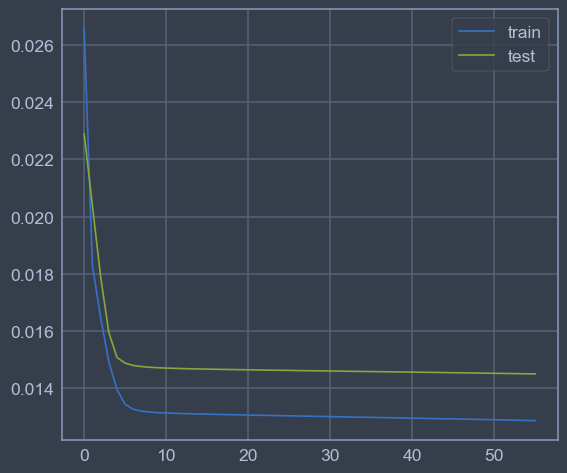

In [66]:
plt.plot(history_days.history['loss'], label = 'train')
plt.plot(history_days.history['val_loss'], label = 'test')
plt.legend(['train', 'test'])

## Making predictions

In [67]:
# train set
yhat_train = model_days.predict(train_X_days)

train_X_days = train_X_days.reshape((train_X_days.shape[0], train_X_days.shape[2]))

inv_yhat_train = np.concatenate((yhat_train, train_X_days[:, 1:]), axis = 1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:, 0]

train_y_days = train_y_days.reshape(-1, 1)
inv_y_train = np.concatenate((train_y_days, train_X_days[:, 1:]), axis = 1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:, 0]

rmse_train = mean_squared_error(inv_y_train, inv_yhat_train, squared = False)
print('Train RMSE: {:.3f}'.format(rmse_train))

# test set
yhat_test = model_days.predict(test_X_days)

test_X_days = test_X_days.reshape((test_X_days.shape[0], test_X_days.shape[2]))

inv_yhat_test = np.concatenate((yhat_test, test_X_days[:, 1:]), axis = 1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:, 0]

test_y_days = test_y_days.reshape(-1, 1)
inv_y_test = np.concatenate((test_y_days, test_X_days[:, 1:]), axis = 1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:, 0]

rmse_test = mean_squared_error(inv_y_test, inv_yhat_test, squared = False)
print('Test RMSE: {:.3f}'.format(rmse_test))

46/46 [==============================] - 1s 2ms/step
Train RMSE: 1157.642
12/12 [==============================] - 0s 2ms/step
Test RMSE: 1239.411


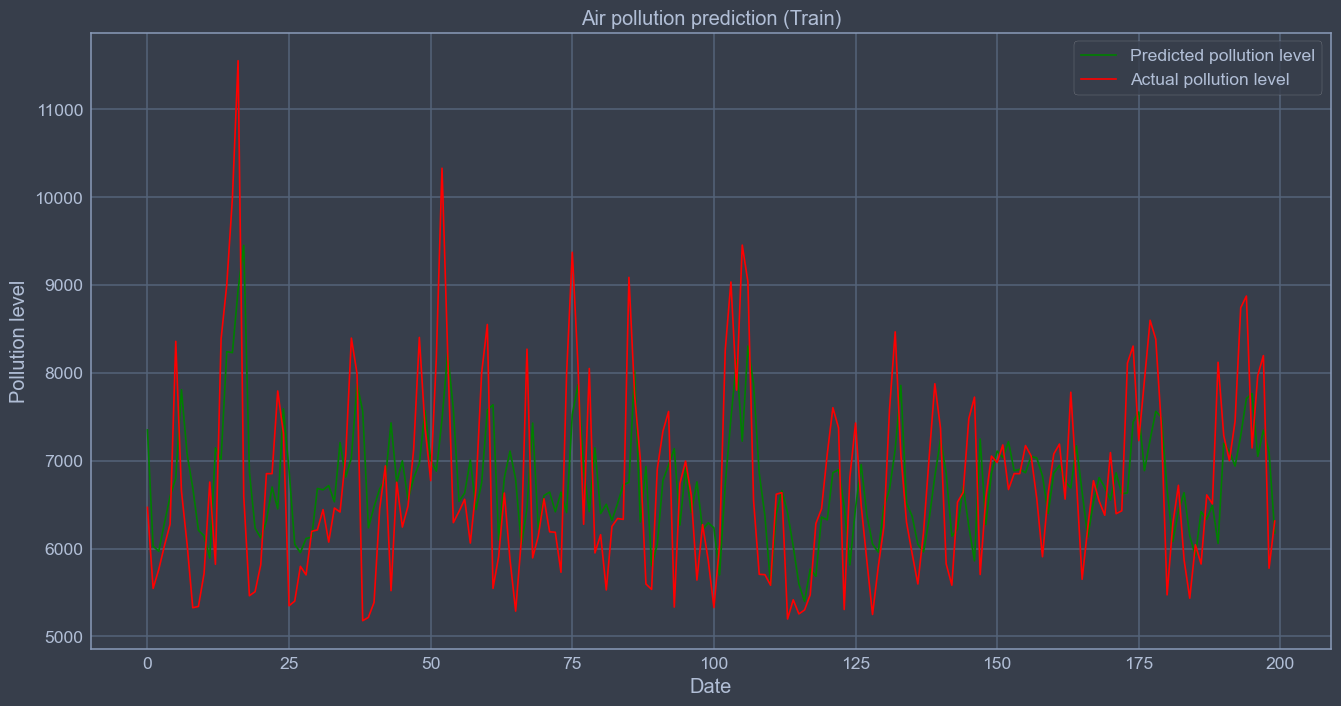

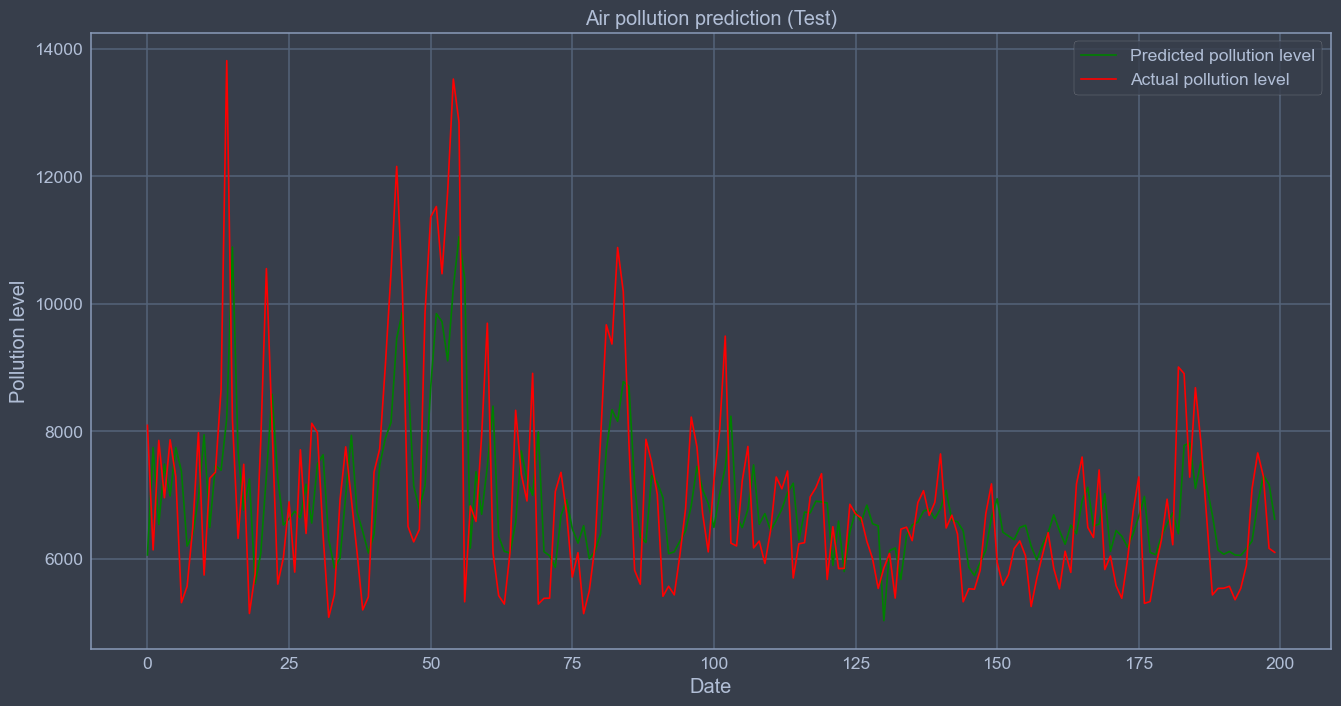

In [68]:
#train
y_train_days = inv_y_train.reshape(-1, 1)
y_pred_train = inv_yhat_train.reshape(-1, 1)

plt.figure(figsize = (16, 8))
plt.plot(y_pred_train[:200, :], color = 'green', label = 'Predicted pollution level')
plt.plot(y_train_days[:200, :], color = 'red', label = 'Actual pollution level')
plt.title('Air pollution prediction (Train)')
plt.xlabel('Date')
plt.ylabel('Pollution level')
plt.legend()
plt.show()

#test
y_test_days = inv_y_test.reshape(-1, 1)
y_pred_test = inv_yhat_test.reshape(-1, 1)

plt.figure(figsize = (16, 8))
plt.plot(y_pred_test[:200, :], color = 'green', label = 'Predicted pollution level')
plt.plot(y_test_days[:200, :], color = 'red', label = 'Actual pollution level')
plt.title('Air pollution prediction (Test)')
plt.xlabel('Date')
plt.ylabel('Pollution level')
plt.legend()
plt.show()

In [69]:
## R2 Score

In [70]:
print('****Train****')
print('R2 score: {}'.format(r2_score(inv_y_train, inv_yhat_train)))

print('****Test****')
print('R2 score: {}'.format(r2_score(inv_y_test, inv_yhat_test)))

****Train****
R2 score: 0.35141236059910697
****Test****
R2 score: 0.3658751677133618


#  Saving the model 

In [71]:
model_RNN_days = model_days.to_json()
with open('model_RNN_days.json', 'w') as json_file:
    json_file.write(model_RNN_days)

#  STEP 8: Coclusion 

##  Data Analysis

    After completing the data analysis step, we found several insights. 

        1. the imoprtant facotrs for dropping the air pollution is 

            1. Temperature
            2. Rain / snow
            3. Wind speed
       

        2. In 2010 and 2013 the pollution rates were the highest. 
        
            I suppose that dispite the fact that the rain, snow and wind rates were the highest during the 2010, the temperature was the lowest. and the government was not ready for that
            in Regard of 2013, the amount of Rain, Snow and Wind during that year was significantly low.

            
        3. During the first two years of the report, the most polluted season was Fall, While from 2012 to 2014, the most polluted season has changed to Winter.

       
        4. Summer was the least polluted season during all 5 years.

            It is because of the rain season in China and high temperature during that season.

       
        5. The most polluted months were usually February or January

        
        6. 2012 year was least polluted year, having the smallest mean pollution rate

            I suppose it is because the rain, snow, wind and temperature were relatively high during that year

            
        I suppose year by year the government tries to overcome the problem with air pollution.   

      
               
   ## Training & Evaluating ANN

        > For predicting the pollution rate for the next hour:

            1. The RNN model with 2 LSTM layers (100 neurons each) performs well showing the 91% r2 score at test set and 90% at train set without any sign of overfitting. 

                It can be seen by the residual plot that the RNN model predicts well for the small as well as for the high values of Pollution rate with the minimum rate of error. 

                
            2. The RNN model with 4 LSTM layers (100 neurons each) + 3 Dropout layers (0.3) performs well showing the 90% r2 score at test set and 88% at train set without any sign of overfitting. 

                It can be seen by the residual plot that the RNN model predicts well for the small as well as for the high values of pollution rate with the minimum rate of error. 

                
            3. It seems that the first model with 2 LSTM layers (100 neurons each) wors better in regard to both performance and the running time.

         
         > For predicting the pollution rate for the next day:

             I have trained the RNN model with 2 LSTM layers (100 neurons each) performs poorly showing only 35% of r2 score on train set and 36% on test set without any sign of overfitting. 
         
             It can be seen by the residual plot that the RNN model predicts poorly the high rates of pollution (>= 8000) Having huge residuals (>= 3000). However, it can also be seen that if the pollution rate is low (< 8000), the model predicts the pollution rate relatevely okay with relativelly low residuals (<= 1000).

                                

    I can conlude that its better to use Model with less LSTM layers to predict the Pollution rate for next hour due to the better performance, lower residuals and better training time.
    
    I suppose that predicting Pollution rate for the next day is still complicated task and more steps and techniques should be applied to boost the performance.
    
    However I think that the model is passible in predicting the low Pollution rate (<8000).

                

                

# THANKS FOR YOUR ATTENTION!